# Single Factor Evaluation Exploration

It will refactor to `py` script for automated testing.

## FactorSort

Evaluation includes:

- Table of each group + factor returns:
    - n_t: number of timestamps(rebalancing dates)
    - mean
    - std
    - t-stat
- ICs: pd.Series of ICs, index is timestamps
    - pearson
    - spearman
- ICIR
    - pearson
    - spearman
- Plot IC time series
- Plot IC histogram
- Plot accumulate returns of group 1, n and factor returns time series
- Histogram of factor returns

## FactorRegression

Evaluation includes:

- ICs: pd.Series of ICs, index is timestamps
    - pearson
    - spearman
- ICIR
    - pearson
    - spearman
- Plot IC time series
- Plot IC histogram
- Accumulated returns of factor time series
- Histogram of factor returns

---

## Test DATA

In [1]:
## Avoid relative imports
%cd ..

/Users/eric/Developer/bagel-factor


In [2]:
import pandas as pd
## Test Data
start_date = pd.Timestamp("2009-01-01")
end_date = pd.Timestamp("2023-12-31")
stock_returns = pd.read_csv("tests/test_stock_returns.csv", index_col=0, parse_dates=True).loc[start_date:end_date]

stock_price = (stock_returns + 1).cumprod()  # using cumulative product to get stock prices
stock_price = stock_price.resample("6ME").last()  # resampling to 6-month end frequency
stock_returns = stock_price.pct_change().dropna()  # get 6-month returns

factor_data = stock_returns.iloc[:-1]  # using 6-month returns(momentum) as factor data
stock_next_returns = stock_returns.shift(-1).dropna()  # next period returns
factor_data = factor_data.iloc[:len(stock_next_returns)]  # aligning factor data with next period returns
factor_data.tail(2)

AAPL      AMGN      AMZN       AXP        BA       CAT  \
date                                                                     
2023-01-31 -0.099281  0.039970 -0.242386  0.126848  0.325529  0.349351   
2023-07-31  0.345858 -0.050991  0.293134 -0.032970  0.130322 -0.005276   

                 CRM      CSCO       CVX       DIS  ...      MSFT       NKE  \
date                                                ...                       
2023-01-31 -0.105967  0.087546  0.113988  0.032422  ... -0.111677  0.116302   
2023-07-31  0.371262  0.090072 -0.098016 -0.213712  ...  0.369918 -0.143190   

                NVDA        PG       SHW       TRV       UNH         V  \
date                                                                     
2023-01-31  0.121828  0.025764 -0.050713  0.202064 -0.098204  0.095607   
2023-07-31  1.296245  0.126618  0.232241 -0.071931  0.042587  0.022609   

                  VZ       WMT  
date                            
2023-01-31 -0.090868  0.093978  
2023-07-31 -0.133338  0.124755  

[2 rows x 30 columns]

In [3]:
stock_next_returns.tail(2)

AAPL      AMGN      AMZN       AXP        BA       CAT  \
date                                                                     
2023-01-31  0.345858 -0.050991  0.293134 -0.032970  0.130322 -0.005276   
2023-07-31 -0.014257  0.238076  0.149232  0.137062  0.092044  0.141237   

                 CRM      CSCO       CVX       DIS  ...      MSFT      NKE  \
date                                                ...                      
2023-01-31  0.371262  0.090072 -0.098016 -0.213712  ...  0.369918 -0.14319   
2023-07-31  0.166401 -0.023090 -0.042150  0.051687  ...  0.115946  0.00613   

                NVDA        PG       SHW       TRV       UNH         V  \
date                                                                     
2023-01-31  1.296245  0.126618  0.232241 -0.071931  0.042587  0.022609   
2023-07-31  0.059475 -0.057158  0.118472  0.112370  0.054552  0.108776   

                  VZ       WMT  
date                            
2023-01-31 -0.133338  0.124755  
2023-07-31  0.131727 -0.006928  

[2 rows x 30 columns]

## FactorSort

---

Table of each group + factor returns

In [4]:
from src.bagel_factor import FactorSort

factor_sort = FactorSort(factor_data=factor_data, 
                         stock_next_returns=stock_next_returns, 
                         group_number=10,
                         name="test_momentum",
                         description="606 momentum factor")
print(f"Factor return (High minus Low): {factor_sort.factor_next_returns.mean():.4%}")

Factor return (High minus Low): 4.5244%


### Table of each group + factor returns

- n_t: number of timestamps(rebalancing dates)
- mean
- std
- t-stat

In [5]:
from scipy import stats

group_result_table = pd.DataFrame(columns=["n_t", "mean", "std", "t_stat", "p_value"], index=factor_sort.portfolio_next_returns.columns)

for group in factor_sort.portfolio_next_returns.columns:
    group_result_table.loc[group, "n_t"] = factor_sort.portfolio_next_returns[group].count()
    group_result_table.loc[group, "mean"] = factor_sort.portfolio_next_returns[group].mean()
    group_result_table.loc[group, "std"] = factor_sort.portfolio_next_returns[group].std()
    t_stat, p_value = stats.ttest_1samp(factor_sort.portfolio_next_returns[group], 0)
    group_result_table.loc[group, "t_stat"] = t_stat  # type: ignore
    group_result_table.loc[group, "p_value"] = p_value  # type: ignore

# Factor statistics
factor_t_stat, factor_p_value = stats.ttest_1samp(factor_sort.factor_next_returns, 0)
group_result_table.loc["H-L", "n_t"] = int(factor_sort.factor_next_returns.count())
group_result_table.loc["H-L", "mean"] = factor_sort.factor_next_returns.mean()
group_result_table.loc["H-L", "std"] = factor_sort.factor_next_returns.std()
group_result_table.loc["H-L", "t_stat"] = factor_t_stat  # type: ignore
group_result_table.loc["H-L", "p_value"] = factor_p_value  # type: ignore

group_result_table

n_t      mean       std    t_stat   p_value
1    29  0.099936  0.126464  4.255505  0.000211
2    29  0.077161  0.114018  3.644352  0.001081
3    29  0.102336    0.0966  5.704927  0.000004
4    29  0.075864  0.081386  5.019776  0.000026
5    29  0.065829  0.093656  3.785144  0.000745
6    29  0.080932   0.10337  4.216235  0.000235
7    29  0.068457  0.107163    3.4401  0.001842
8    29  0.091865  0.101424  4.877612  0.000039
9    29   0.07988  0.092597  4.645542  0.000073
10   29   0.14518  0.139103  5.620449  0.000005
H-L  29  0.045244  0.148879  1.636556  0.112916

<Axes: title={'center': 'Mean Returns by Group'}, xlabel='Group', ylabel='Mean Return'>

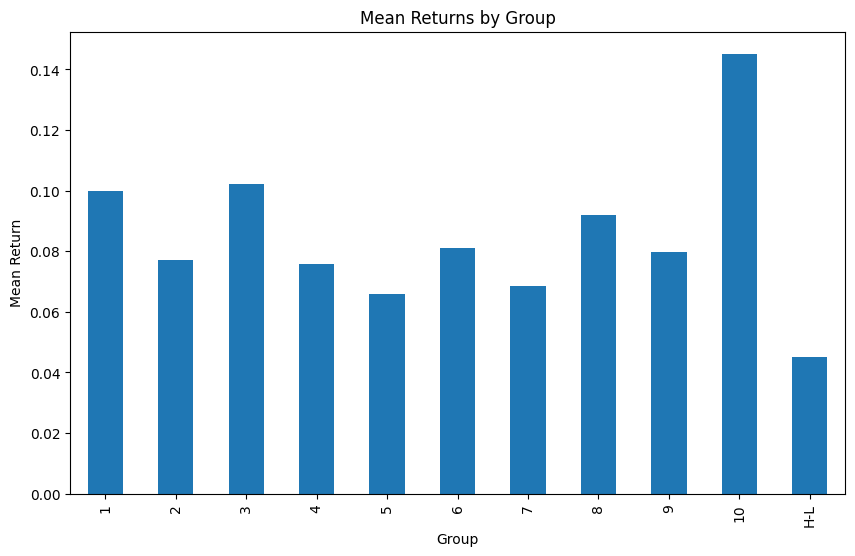

In [6]:
group_result_table["mean"].plot(kind="bar", title="Mean Returns by Group", ylabel="Mean Return", xlabel="Group", figsize=(10, 6))

### ICs and ICIR

---

<Axes: title={'center': 'ICs over Time'}, xlabel='Date', ylabel='IC'>

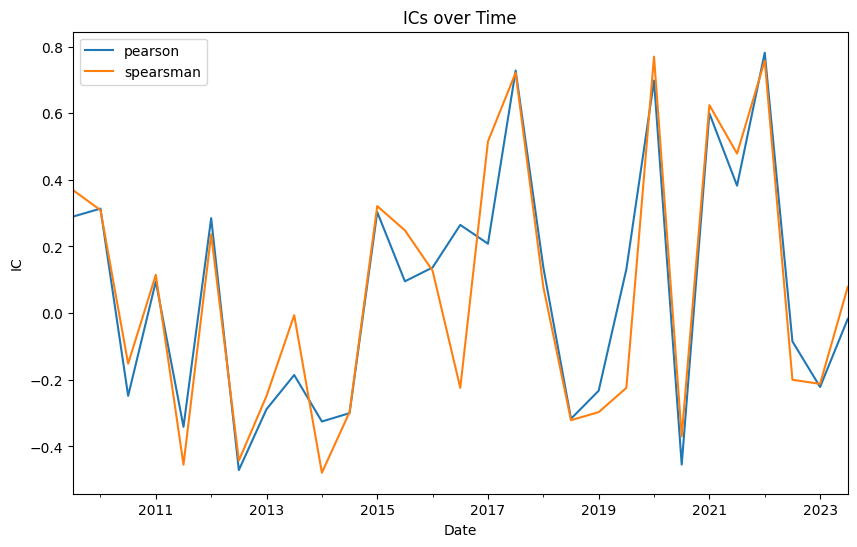

In [30]:
pearson_ic = pd.Series(index=factor_sort.portfolio_next_returns.index, name="pearson_ic")
spearsman_ic = pd.Series(index=factor_sort.portfolio_next_returns.index, name="spearsman_ic")

for date in factor_sort.portfolio_next_returns.index:
    # correlation between group number(portfolio_next_returns columns) and next period returns
    pearson_ic[date] = factor_sort.portfolio_next_returns.loc[date].corr(factor_sort.portfolio_next_returns.columns.to_series(), method="pearson")
    spearsman_ic[date] = factor_sort.portfolio_next_returns.loc[date].corr(factor_sort.portfolio_next_returns.columns.to_series(), method="spearman")

ICs = pd.DataFrame({"pearson": pearson_ic, "spearsman": spearsman_ic})
ICs.plot(title="ICs over Time", ylabel="IC", xlabel="Date", figsize=(10, 6))

In [31]:
ic_icir_table = pd.DataFrame(columns=["ICs mean", "std", "ICIR"])
ic_icir_table["ICs mean"] = ICs.mean()
ic_icir_table["std"] = ICs.std()
ic_icir_table["ICIR"] = ic_icir_table["ICs mean"] / ic_icir_table["std"]
ic_icir_table

ICs mean       std      ICIR
pearson    0.067729  0.362165  0.187012
spearsman  0.062905  0.390469  0.161101

### Accumulated returns of group 1, n and factor returns time series
---

<Axes: title={'center': 'Cumulative Returns'}, xlabel='Date', ylabel='Cumulative Return'>

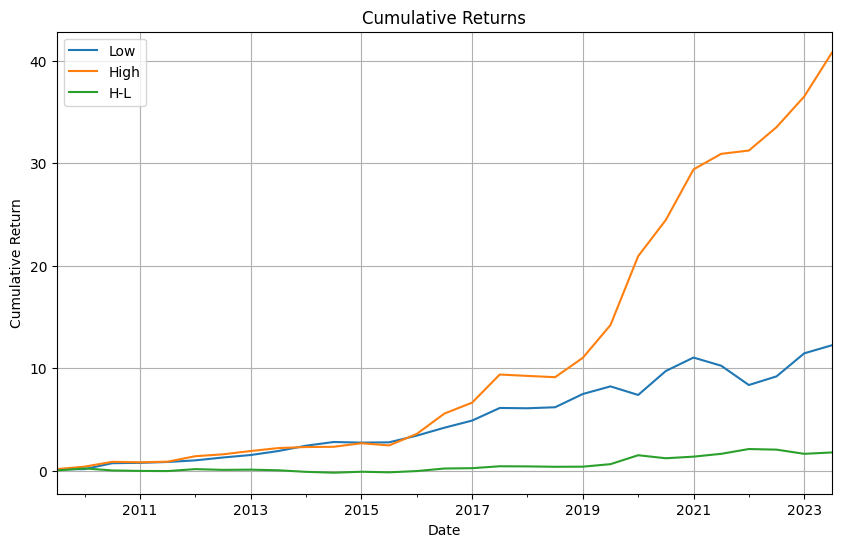

In [37]:
returns = pd.concat([factor_sort.portfolio_next_returns.iloc[:, 0], 
                     factor_sort.portfolio_next_returns.iloc[:, -1], 
                     factor_sort.factor_next_returns], axis=1)
accumulated_returns = (returns + 1).cumprod() - 1  # cumulative returns
accumulated_returns.columns = ["Low", "High", "H-L"]
accumulated_returns.plot(title="Cumulative Returns", ylabel="Cumulative Return", xlabel="Date", figsize=(10, 6), grid=True)

### Histogram of factor returns

---


<Axes: title={'center': 'Factor Next Returns Distribution'}, xlabel='Next Returns', ylabel='Frequency'>

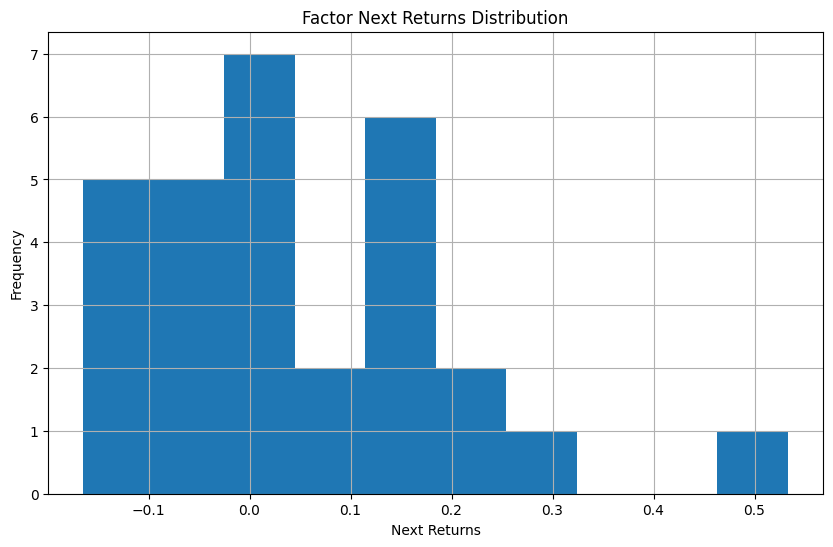

In [42]:
factor_sort.factor_next_returns.plot(kind="hist", title="Factor Next Returns Distribution", xlabel="Next Returns", ylabel="Frequency", figsize=(10, 6), grid=True)

In [62]:
from datetime import datetime
factor_sort.portfolio_next_returns.loc[[pd.Timestamp(datetime(2017, 7, 31)),
                                        pd.Timestamp(datetime(2017, 1, 31))]]

1         2         3         4         5         6   \
date                                                                     
2017-07-31  0.209283  0.189676  0.086173  0.256891  0.207634  0.208079   
2017-01-31  0.133919  0.131730  0.117213  0.091215  0.162943  0.154012   

                  7         8         9         10  
date                                                
2017-07-31  0.317464  0.234466  0.301442  0.359786  
2017-01-31 -0.062952  0.180537  0.248357  0.161778

## FactorRegression

---

In [ ]:
from src.bagel_factor import FactorRegression

factor_regression = FactorRegression(factor_data=factor_data,
                                     stock_next_returns=stock_next_returns,
                                     name="test_momentum_regression",
                                     description="606 momentum factor regression")
print(f"Factor return (Slope): {factor_sort.factor_next_returns.mean():.4%}")

Factor return (Slope): 4.5244%


### ICs and ICIR

<Axes: title={'center': 'ICs over Time (Regression)'}, xlabel='Date', ylabel='IC'>

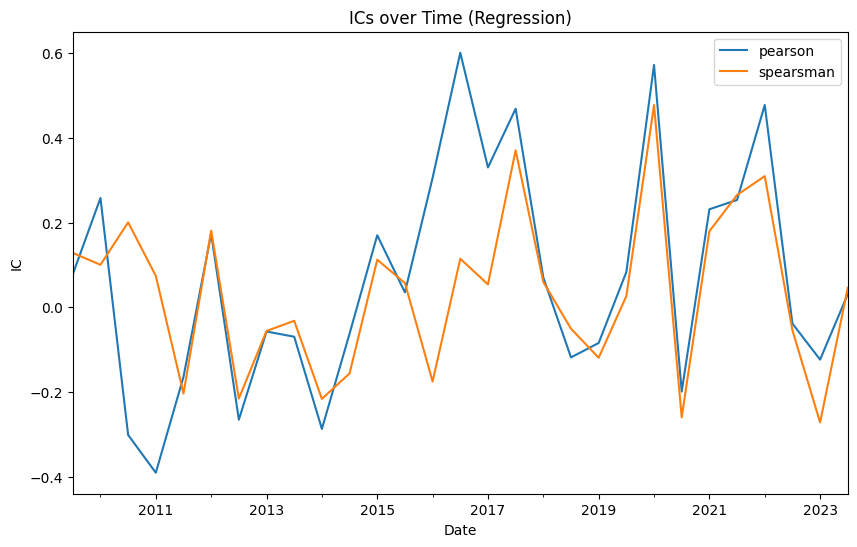

In [46]:
ICs_regression = pd.DataFrame(columns=["pearson", "spearsman"], index=factor_regression.factor_next_returns.index)

for date in factor_regression.factor_next_returns.index:
    # correlation between factor data and next period returns
    ICs_regression.loc[date, "pearson"] = factor_regression.factor_data.loc[date].corr(factor_regression.stock_next_returns.loc[date], method="pearson")
    ICs_regression.loc[date, "spearsman"] = factor_regression.factor_data.loc[date].corr(factor_regression.stock_next_returns.loc[date], method="spearman")

ICs_regression.plot(title="ICs over Time (Regression)", ylabel="IC", xlabel="Date", figsize=(10, 6))

<Axes: title={'center': 'First Period Scatter Plot'}, xlabel='Factor Data', ylabel='Stock Next Returns'>

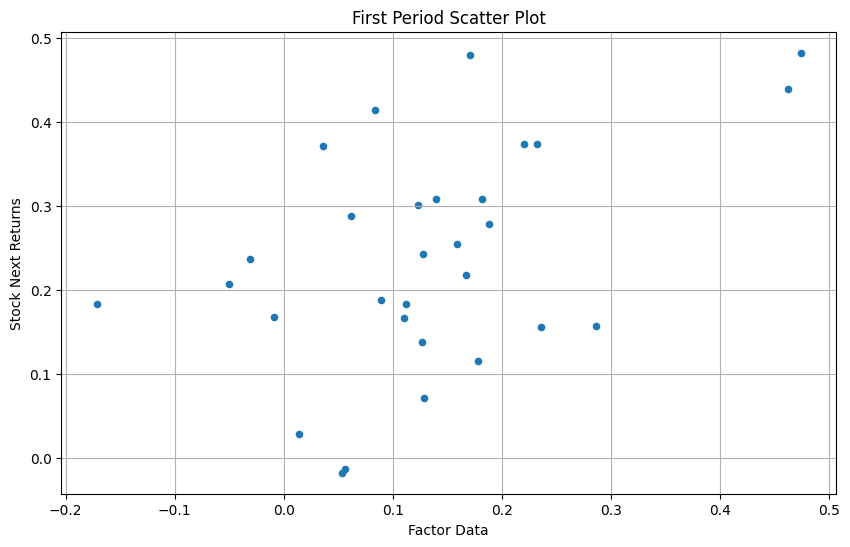

In [63]:
first_t = pd.concat([factor_regression.factor_data.loc[pd.Timestamp("2017-07-31")], 
                     factor_regression.stock_next_returns.loc[pd.Timestamp("2017-07-31")]], axis=1)
first_t.columns = ["factor_data", "stock_next_returns"]
first_t.plot(kind="scatter", 
             x="factor_data", 
             y="stock_next_returns", 
             title="First Period Scatter Plot", xlabel="Factor Data", ylabel="Stock Next Returns", figsize=(10, 6), grid=True)

In [47]:
ICIR_table_regression = pd.DataFrame(columns=["ICs mean", "std", "ICIR"])
ICIR_table_regression["ICs mean"] = ICs_regression.mean()
ICIR_table_regression["std"] = ICs_regression.std()
ICIR_table_regression["ICIR"] = ICIR_table_regression["ICs mean"] / ICIR_table_regression["std"]
ICIR_table_regression

ICs mean       std      ICIR
pearson    0.068245  0.265724  0.256827
spearsman  0.032688  0.191769  0.170453

### Accumulated returns of factor time series
---

<Axes: title={'center': 'Cumulative Returns (Regression)'}, xlabel='Date', ylabel='Cumulative Return'>

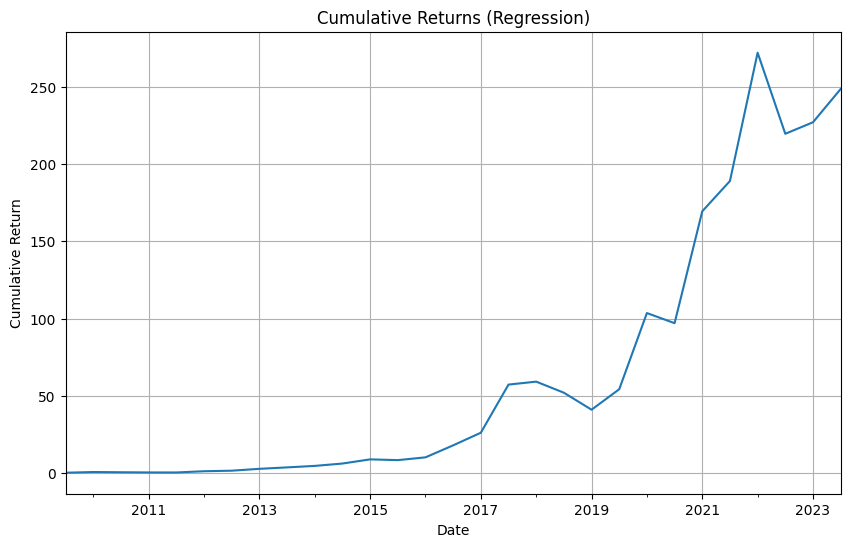

In [54]:
accumulated_returns_regression = (factor_regression.factor_next_returns + 1).cumprod() - 1  # cumulative returns
accumulated_returns_regression.plot(title="Cumulative Returns (Regression)", ylabel="Cumulative Return", xlabel="Date", figsize=(10, 6), grid=True)

<Axes: title={'center': 'Factor Next Returns Distribution (Regression)'}, xlabel='Next Returns', ylabel='Frequency'>

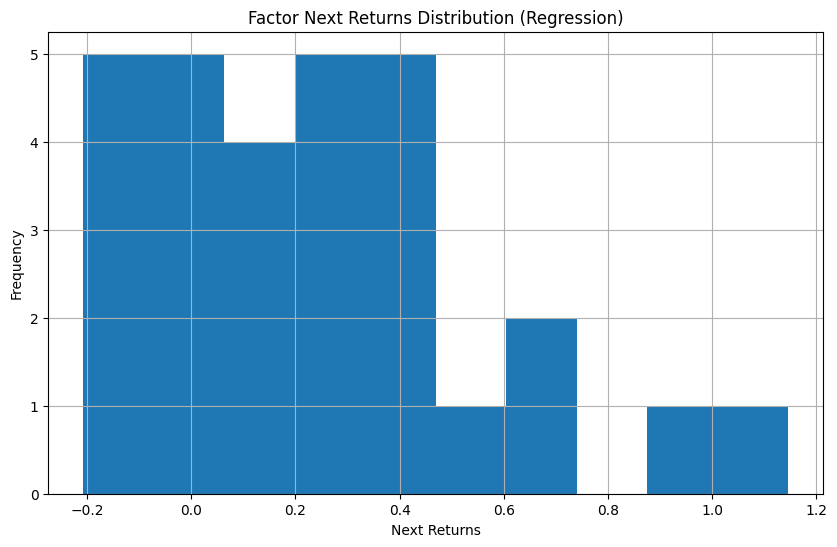

In [55]:
factor_regression.factor_next_returns.plot(kind="hist",
                                            title="Factor Next Returns Distribution (Regression)", 
                                            xlabel="Next Returns", 
                                            ylabel="Frequency", 
                                            figsize=(10, 6), 
                                            grid=True)

In [56]:
factor_regression.factor_next_returns

date
2009-07-31    0.310794
2010-01-31    0.346118
2010-07-31   -0.086240
2011-01-31   -0.076724
2011-07-31   -0.006938
2012-01-31    0.537098
2012-07-31    0.152972
2013-01-31    0.462678
2013-07-31    0.242874
2014-01-31    0.202563
2014-07-31    0.266185
2015-01-31    0.372232
2015-07-31   -0.049808
2016-01-31    0.190215
2016-07-31    0.689797
2017-01-31    0.429495
2017-07-31    1.145602
2018-01-31    0.032720
2018-07-31   -0.118919
2019-01-31   -0.207098
2019-07-31    0.314325
2020-01-31    0.891302
2020-07-31   -0.062537
2021-01-31    0.737933
2021-07-31    0.114992
2022-01-31    0.436772
2022-07-31   -0.192055
2023-01-31    0.033726
2023-07-31    0.094411
Freq: 6ME, dtype: float64